# PDBbind dataset

> 这里为了加快实验进展，直接使用PDBbind提供的pocket和ligand数据，然后将其反序列化得到其序列表示，最后融合到PocketDTA模型中，得到预测结果。跳过了从AlphaFold中提取预测空间结构以及使用P2Rank进行口袋预测的过程。

##  1 Read raw data from the PDBbind

> The raw data can be downloaded from [PDBbind-CN Repository]( http://www.pdbbind.org.cn/download.php).

As each pdb name file contains 4 file:
- 1a0q_ligand.mol2 // for mol structure
- 1a0q_ligand.sdf  // for mol structure
- 1a0q_pocket.pdb   // for pocket structure
- 1a0q_protein.pdb   // for protein structure

### 1.1 PDB id extraction [Done]

In [1]:
import pandas as pd 
import numpy as np
from tqdm import tqdm  

In [2]:
pre = "../../../data/dta-datasets/PDBbind"

In [3]:
pdbbind_id = pd.read_csv(f'{pre}/PDBbind_index/index/INDEX_general_PL_name.2020', sep="  ", comment='#', header=None, names=['pdb', 'year', 'uid', 'name', 'others'], engine='python')
pdbbind_id

,pdb,year,uid,name,others
0,6mu1,2018,P29994,"INOSITOL 1,4,5-TRISPHOSPHATE RECEPTOR TYPE 1",None
1,3t8s,2011,P29994,"INOSITOL 1,4,5-TRISPHOSPHATE RECEPTOR TYPE 1",None
2,1n4k,2002,P11881,"INOSITOL 1,4,5-TRISPHOSPHATE RECEPTOR TYPE 1",None
3,5urm,2017,O75643,U5 SMALL NUCLEAR RIBONUCLEOPROTEIN 200 KDA HEL...,None
4,5urj,2017,O75643,U5 SMALL NUCLEAR RIBONUCLEOPROTEIN 200 KDA HEL...,None
...,...,...,...,...,...
19438,1swi,1996,P03069,GCN4P1,None
19439,2lk1,2011,P52756,RNA-BINDING PROTEIN 5,None
19440,6eiz,2018,------,CC-HEX2,None
19441,2ly0,2013,Q6XT21,MEMBRANE ION CHANNEL M2,None


In [4]:
pdbbind_id.shape  # all entries

(19443, 5)

In [5]:
pdbbind_id = pdbbind_id[['pdb','uid']] # contain only the pdb name and uid
pdbbind_id

,pdb,uid
0,6mu1,P29994
1,3t8s,P29994
2,1n4k,P11881
3,5urm,O75643
4,5urj,O75643
...,...,...
19438,1swi,P03069
19439,2lk1,P52756
19440,6eiz,------
19441,2ly0,Q6XT21


In [6]:
pdbbind_id['pdb']

0        6mu1
1        3t8s
2        1n4k
3        5urm
4        5urj
         ... 
19438    1swi
19439    2lk1
19440    6eiz
19441    2ly0
19442    2lyw
Name: pdb, Length: 19443, dtype: object

In [7]:
pdbbind_id['pdb'].str.upper()

0        6MU1
1        3T8S
2        1N4K
3        5URM
4        5URJ
         ... 
19438    1SWI
19439    2LK1
19440    6EIZ
19441    2LY0
19442    2LYW
Name: pdb, Length: 19443, dtype: object

In [8]:
pdbbind_id

,pdb,uid
0,6mu1,P29994
1,3t8s,P29994
2,1n4k,P11881
3,5urm,O75643
4,5urj,O75643
...,...,...
19438,1swi,P03069
19439,2lk1,P52756
19440,6eiz,------
19441,2ly0,Q6XT21


In [9]:
pdbbind_id['pdb'] = pdbbind_id['pdb'].str.upper()
pdbbind_id

C:\Users\Marine\AppData\Local\Temp\ipykernel_23968\3985334227.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdbbind_id['pdb'] = pdbbind_id['pdb'].str.upper()


,pdb,uid
0,6MU1,P29994
1,3T8S,P29994
2,1N4K,P11881
3,5URM,O75643
4,5URJ,O75643
...,...,...
19438,1SWI,P03069
19439,2LK1,P52756
19440,6EIZ,------
19441,2LY0,Q6XT21


In [10]:
len(pdbbind_id["uid"].unique())  # '------' for unknown

3890

In [11]:
pdb_uid_dict = dict(zip(pdbbind_id['pdb'], pdbbind_id['uid'],))
pdb_uid_dict

{'6MU1': 'P29994',
 '3T8S': 'P29994',
 '1N4K': 'P11881',
 '5URM': 'O75643',
 '5URJ': 'O75643',
 '5URK': 'O75643',
 '3EQL': 'Q9Z9H6',
 '1ZYR': 'Q5SHR6',
 '3DXJ': 'Q5SHR6',
 '4WZ6': 'P13569',
 '6O2P': 'P13569',
 '5UAH': 'P0A7Z4',
 '5UAL': 'P0A7Z4',
 '4ZH4': 'P0A7Z4',
 '4ZH3': 'P0A7Z4',
 '4ZH2': 'P0A7Z4',
 '4XSX': 'A7ZSI4',
 '4XSY': 'A7ZSI4',
 '4XSZ': 'A7ZSI4',
 '4MEX': 'P0A7Z4',
 '4KN4': 'P0A7Z4',
 '4KN7': 'P0A7Z4',
 '4KMU': 'P0A7Z4',
 '5UAC': 'P0A7Z4',
 '5SWG': 'P42336',
 '5SXK': 'P42336',
 '4WAF': 'P42336',
 '5XGH': 'P42336',
 '6GVG': 'P42336',
 '6GVH': 'P42336',
 '6OCO': 'O00329',
 '5UK8': 'P42336',
 '5ITD': 'P42336',
 '5UL1': 'P42336',
 '6GVI': 'P42336',
 '6PYS': 'P42336',
 '5UKJ': 'P42336',
 '6GVF': 'P42336',
 '4L23': 'P42336',
 '3HHM': 'P42336',
 '6OAC': 'P42336',
 '6PYU': 'O00329',
 '4YKN': 'P27986',
 '3ZIM': 'P42336',
 '4JPS': 'P42336',
 '5DXU': 'O00329',
 '5VLR': 'O00329',
 '5UBT': 'O00329',
 '4TV3': 'P42336',
 '6PYR': 'O00329',
 '5DXH': 'P42336',
 '6G6W': 'O00329',
 '5DXT': 'P4

In [12]:
len(pdb_uid_dict)

19443

In [13]:
pdbbind_id.to_csv(f'{pre}/pdbbind_id.csv', index=None)

###  1.2 Protein sequence extract [Done]

通过PDB文件使用Biopython包提取对应的残基序列

In [2]:
import pandas as pd 
import numpy as np
from tqdm import tqdm  
import os
from Bio import PDB
import warnings

warnings.filterwarnings("ignore")

In [2]:
pre = "../../../data/dta-datasets/PDBbind"

In [3]:
pdbbind_id = pd.read_csv(f'{pre}/pdbbind_id.csv')
pdbbind_id

,pdb,uid
0,6MU1,P29994
1,3T8S,P29994
2,1N4K,P11881
3,5URM,O75643
4,5URJ,O75643
...,...,...
19438,1SWI,P03069
19439,2LK1,P52756
19440,6EIZ,------
19441,2LY0,Q6XT21


In [4]:
pdbbind_id.insert(pdbbind_id.shape[1], 'sequence', '')
pdbbind_id.insert(pdbbind_id.shape[1], 'protein_length', '')

In [5]:
pdbbind_id

,pdb,uid,sequence,protein_length
0,6MU1,P29994,,
1,3T8S,P29994,,
2,1N4K,P11881,,
3,5URM,O75643,,
4,5URJ,O75643,,
...,...,...,...,...
19438,1SWI,P03069,,
19439,2LK1,P52756,,
19440,6EIZ,------,,
19441,2LY0,Q6XT21,,


In [6]:
for index in tqdm(pdbbind_id.index, total=pdbbind_id.shape[0]): # pdbbind_id.shape[0]
    current_pdb = pdbbind_id.at[index, 'pdb'].lower() 
    file_path = pre + "/PDBbind_file/" + current_pdb + "/"
    
    protein_name = current_pdb + "_protein.pdb"
    protein_file = os.path.join(file_path, protein_name)

    # 创建PDB解析器
    parser = PDB.PDBParser()
    # 读取PDB文件
    protein_structure = parser.get_structure(current_pdb, protein_file)
    # 提取蛋白质信息
    residues = []
    for model in protein_structure:
        for chain in model:
            for residue in chain:
                if residue.get_id()[0] != " ": # skip the non-residue HETATM
                    continue
                elif PDB.is_aa(residue):
                    residues.append(PDB.Polypeptide.three_to_one(residue.get_resname()))
    sequence = ''.join(residues)
    pdbbind_id.at[index, 'sequence'] = sequence
    pdbbind_id.at[index, 'protein_length'] = len(sequence)

100%|██████████| 19443/19443 [46:13<00:00,  7.01it/s]  


In [7]:
pdbbind_id

,pdb,uid,sequence,protein_length
0,6MU1,P29994,KMSSFLHIGDICSLYAEGSTNGFISTLGLVDDRCVVQPEAGDLNNP...,2149
1,3T8S,P29994,SFLHIGDICSLYAEGSTNGFISTLGLVDDRCVVQPEAGDLNNPPKK...,482
2,1N4K,P11881,GGDVVRLFHAEQEKFLTCDEHRKKQHVFLRTTGRQSATSATSSKAL...,292
3,5URM,O75643,APRQVLDLEDLVFTQGSHFMANKRCQLPDGSFRRQRKGYEEVHVPA...,1718
4,5URJ,O75643,LAPRQVLDLEDLVFTQGSHFMANKRCQLPDGSFRRQRKGYEEVHVP...,1707
...,...,...,...,...
19438,1SWI,P03069,RMKQLEDKVEELLSKAYHLENEVARLKKLVGRMKQLEDKVEELLSK...,91
19439,2LK1,P52756,KFEDWLCNKCCLNNFRKRLKCFRCGADKFD,30
19440,6EIZ,------,GEIAKSLKEIAKSLKEIAWSLKEIAKSLKGGEIAKSLKEIAKSLKE...,178
19441,2LY0,Q6XT21,SNDSSDPLVVAANIIGILHLILWILDRLFFKSNDSSDPLVVAANII...,124


In [8]:
len(pdbbind_id["sequence"].notnull())

19443

In [9]:
pdbbind_id.to_csv(f'{pre}/PDBbind_pocket/pdbbind_proteins.csv', index=None)

### 1.3 pocket file generate

为每一个蛋白质生成类似P2Rank一样的CSV文件，方便后续查阅，因为CVS文件不能保存列表，只能这样子了。模仿下面的图设计，全厂蛋白质然后是pocket最后一列为1即可。

In [1]:
import pandas as pd 
import numpy as np
from tqdm import tqdm  
import os
from Bio import PDB
import warnings

warnings.filterwarnings("ignore")

In [2]:
csv_path = "../../../data/dta-datasets/Davis/p2rank/predict_protein_list/AF-A4VCI5-F1-model_v4.pdb_residues.csv"
pdb_residues = pd.read_csv(csv_path)
pdb_residues.columns = pdb_residues.columns.str.strip()  # 原始表格列名有空格，这里去除方便索引
pdb_residues

,chain,residue_label,residue_name,score,zscore,probability,pocket
0,A,1,GLU,0.0174,-0.3856,0.0003,0
1,A,2,ARG,0.0640,-0.3616,0.0009,0
2,A,3,PHE,0.0804,-0.3532,0.0012,0
3,A,4,GLU,0.0611,-0.3631,0.0009,0
4,A,5,LEU,0.0081,-0.3903,0.0002,0
...,...,...,...,...,...,...,...
537,A,538,PHE,0.1234,-0.3311,0.0023,0
538,A,539,SER,0.1104,-0.3379,0.0019,0
539,A,540,LEU,0.0484,-0.3697,0.0007,0
540,A,541,LYS,0.0341,-0.3770,0.0005,0


In [3]:
pre = "../../../data/dta-datasets/PDBbind"

In [4]:
pdbbind_proteins = pd.read_csv(f'{pre}/pdbbind_proteins.csv')
pdbbind_proteins

,pdb,uid,sequence,protein_length
0,6MU1,P29994,KMSSFLHIGDICSLYAEGSTNGFISTLGLVDDRCVVQPEAGDLNNP...,2149
1,3T8S,P29994,SFLHIGDICSLYAEGSTNGFISTLGLVDDRCVVQPEAGDLNNPPKK...,482
2,1N4K,P11881,GGDVVRLFHAEQEKFLTCDEHRKKQHVFLRTTGRQSATSATSSKAL...,292
3,5URM,O75643,APRQVLDLEDLVFTQGSHFMANKRCQLPDGSFRRQRKGYEEVHVPA...,1718
4,5URJ,O75643,LAPRQVLDLEDLVFTQGSHFMANKRCQLPDGSFRRQRKGYEEVHVP...,1707
...,...,...,...,...
19438,1SWI,P03069,RMKQLEDKVEELLSKAYHLENEVARLKKLVGRMKQLEDKVEELLSK...,91
19439,2LK1,P52756,KFEDWLCNKCCLNNFRKRLKCFRCGADKFD,30
19440,6EIZ,------,GEIAKSLKEIAKSLKEIAWSLKEIAKSLKGGEIAKSLKEIAKSLKE...,178
19441,2LY0,Q6XT21,SNDSSDPLVVAANIIGILHLILWILDRLFFKSNDSSDPLVVAANII...,124


遍历每一行，读取pdb对应的protein和pocket文件，用protein文件构成前3列基本信息，pocket仅填充最后一列

In [5]:
for index in tqdm(pdbbind_proteins.index, total=pdbbind_proteins.shape[0]): # pdbbind_proteins.shape[0]
    # 每一个蛋白质新建一张表，方便后续保存
    protein_df = pd.DataFrame(columns=('chain', 'residue_label', 'residue_name', 'pocket'))  
    current_pdb = pdbbind_proteins.at[index, 'pdb'].lower() 
    file_path = pre + "/PDBbind_file/" + current_pdb + "/"
    # 读取当前蛋白质信息
    protein_name = current_pdb + "_protein.pdb"
    protein_file = os.path.join(file_path, protein_name)
    # 创建PDB解析器
    parser = PDB.PDBParser()
    # 读取PDB文件
    protein_structure = parser.get_structure(current_pdb, protein_file)
    # 提取具体序列信息

    for model in protein_structure:
        for chain in model:
            for residue in chain:
                if residue.get_id()[0] != " ": # skip the non-residue HETATM
                    continue
                elif PDB.is_aa(residue):
                    protein_df = protein_df.append(pd.DataFrame({
                        'chain':[chain.get_id()],
                        'residue_label':[residue.get_id()[1]],
                        'residue_name':[residue.get_resname()],
                        'pocket':0 # 0表示非口袋
                        }), ignore_index=True)
    
    # 读取当前口袋信息
    pocket_name = current_pdb + "_pocket.pdb"
    pocket_file = os.path.join(file_path, pocket_name)
    
    # 读取Pocket文件
    pocket_structure = parser.get_structure(current_pdb, pocket_file)
    # 提取口袋信息
    pocket_list = []
    for model in pocket_structure:
        for chain in model:
            for residue in chain:
                if residue.get_id()[0] != " ": # skip the non-residue HETATM
                    continue
                elif PDB.is_aa(residue):
                    current_chain = chain.get_id() 
                    current_index = residue.get_id()[1]
                    protein_df.loc[(protein_df['chain']==current_chain) & (protein_df['residue_label']==current_index), 'pocket'] = 1 # 1表示口袋

    # 保存文件到文件夹
    protein_df.to_csv(f'{file_path}{current_pdb}_proteins.csv', index=None)

100%|██████████| 19443/19443 [3:57:57<00:00,  1.36it/s]  


### 1.4 affinity file merge [Done]

In [1]:
# form tankbind/utils
import pandas as pd
def read_pdbbind_data(fileName):
    with open(fileName) as f:
        a = f.readlines()
    info = []
    for line in a:
        if line[0] == '#':
            continue
        lines, ligand = line.split('//')
        pdb, resolution, year, affinity, raw = lines.strip().split('  ')
        ligand = ligand.strip().split('(')[1].split(')')[0]
        # print(lines, ligand)
        info.append([pdb, resolution, year, affinity, raw, ligand])
    info = pd.DataFrame(info, columns=['pdb', 'resolution', 'year', 'affinity', 'raw', 'ligand'])
    info.year = info.year.astype(int)
    info.affinity = info.affinity.astype(float)
    return info

In [2]:
pre = "../../../data/dta-datasets/PDBbind"

In [3]:
affinity_file = read_pdbbind_data(f'{pre}/PDBbind_index/index/INDEX_general_PL_data.2020')
affinity_file

,pdb,resolution,year,affinity,raw,ligand
0,3zzf,2.20,2012,0.40,Ki=400mM,NLG
1,3gww,2.46,2009,0.45,IC50=355mM,SFX
2,1w8l,1.80,2004,0.49,Ki=320mM,1P3
3,3fqa,2.35,2009,0.49,IC50=320mM,GAB&PMP
4,1zsb,2.00,1996,0.60,Kd=250mM,AZM
...,...,...,...,...,...,...
19438,7cpa,2.00,1994,13.96,Ki=11fM,FVF
19439,2xuf,2.55,2010,14.39,Kd=4.1fM,TZ4
19440,1avd,2.70,1994,15.00,Kd=1fM,BTN
19441,2xui,2.60,2010,15.00,Kd=1.0fM,TZ5


In [4]:
affinity_file['pdb'] = affinity_file['pdb'].str.upper()
affinity_file

,pdb,resolution,year,affinity,raw,ligand
0,3ZZF,2.20,2012,0.40,Ki=400mM,NLG
1,3GWW,2.46,2009,0.45,IC50=355mM,SFX
2,1W8L,1.80,2004,0.49,Ki=320mM,1P3
3,3FQA,2.35,2009,0.49,IC50=320mM,GAB&PMP
4,1ZSB,2.00,1996,0.60,Kd=250mM,AZM
...,...,...,...,...,...,...
19438,7CPA,2.00,1994,13.96,Ki=11fM,FVF
19439,2XUF,2.55,2010,14.39,Kd=4.1fM,TZ4
19440,1AVD,2.70,1994,15.00,Kd=1fM,BTN
19441,2XUI,2.60,2010,15.00,Kd=1.0fM,TZ5


merge the sequence into the affinity file

In [5]:
pdbbind_proteins = pd.read_csv(f'{pre}/pdbbind_proteins.csv')
pdbbind_proteins

,pdb,uid,sequence,protein_length
0,6MU1,P29994,KMSSFLHIGDICSLYAEGSTNGFISTLGLVDDRCVVQPEAGDLNNP...,2149
1,3T8S,P29994,SFLHIGDICSLYAEGSTNGFISTLGLVDDRCVVQPEAGDLNNPPKK...,482
2,1N4K,P11881,GGDVVRLFHAEQEKFLTCDEHRKKQHVFLRTTGRQSATSATSSKAL...,292
3,5URM,O75643,APRQVLDLEDLVFTQGSHFMANKRCQLPDGSFRRQRKGYEEVHVPA...,1718
4,5URJ,O75643,LAPRQVLDLEDLVFTQGSHFMANKRCQLPDGSFRRQRKGYEEVHVP...,1707
...,...,...,...,...
19438,1SWI,P03069,RMKQLEDKVEELLSKAYHLENEVARLKKLVGRMKQLEDKVEELLSK...,91
19439,2LK1,P52756,KFEDWLCNKCCLNNFRKRLKCFRCGADKFD,30
19440,6EIZ,------,GEIAKSLKEIAKSLKEIAWSLKEIAKSLKGGEIAKSLKEIAKSLKE...,178
19441,2LY0,Q6XT21,SNDSSDPLVVAANIIGILHLILWILDRLFFKSNDSSDPLVVAANII...,124


In [6]:
pdbbind_affinities = affinity_file.merge(pdbbind_proteins, on=['pdb'])
pdbbind_affinities

,pdb,resolution,year,affinity,raw,ligand,uid,sequence,protein_length
0,3ZZF,2.20,2012,0.40,Ki=400mM,NLG,Q01217,NGFSATRSTVIQLLNNISTKREVEQYLKYFTSVSQQQFAVIKVGGA...,1161
1,3GWW,2.46,2009,0.45,IC50=355mM,SFX,O67854,REHWATRLGLILAMAGNAVGLGNFLRFPVQAAENGGGAFMIPYIIA...,501
2,1W8L,1.80,2004,0.49,Ki=320mM,1P3,P62937,MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...,165
3,3FQA,2.35,2009,0.49,IC50=320mM,GAB&PMP,P24630,KTIKSDEIFAAAQKLMPGGVSSPVRAFKSVGGQPIVFDRVKDAYAW...,852
4,1ZSB,2.00,1996,0.60,Kd=250mM,AZM,P00918,HWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPLSV...,257
...,...,...,...,...,...,...,...,...,...
19438,7CPA,2.00,1994,13.96,Ki=11fM,FVF,P00730,ARSTNTFNYATYHTLDEIYDFMDLLVAQHPELVSKLQIGRSYEGRP...,307
19439,2XUF,2.55,2010,14.39,Kd=4.1fM,TZ4,P21836,REDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRRFM...,534
19440,1AVD,2.70,1994,15.00,Kd=1fM,BTN,P02701,KCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKESP...,494
19441,2XUI,2.60,2010,15.00,Kd=1.0fM,TZ5,P21836,EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...,536


In [7]:
pdbbind_affinities[['pdb', 'uid', 'sequence', 'ligand','affinity']].to_csv(f'{pre}/pdbbind_affinities.csv', index=None)

### 1.5 Protein pkl building 19408->19404

In [1]:
import warnings
from torchdrug import data, layers, transforms
from rdkit import Chem
import pandas as pd
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [2]:
pre = "../../../data/dta-datasets/PDBbind"
affinity_csv = '../../../data/dta-datasets/PDBbind/pdbbind_affinities.csv'

In [3]:
pdbbind_affinities= pd.read_csv(affinity_csv)
pdbbind_affinities

,pdb,uid,sequence,ligand,affinity
0,3ZZF,Q01217,NGFSATRSTVIQLLNNISTKREVEQYLKYFTSVSQQQFAVIKVGGA...,NLG,0.40
1,3GWW,O67854,REHWATRLGLILAMAGNAVGLGNFLRFPVQAAENGGGAFMIPYIIA...,SFX,0.45
2,1W8L,P62937,MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...,1P3,0.49
3,3FQA,P24630,KTIKSDEIFAAAQKLMPGGVSSPVRAFKSVGGQPIVFDRVKDAYAW...,GAB&PMP,0.49
4,1ZSB,P00918,HWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPLSV...,AZM,0.60
...,...,...,...,...,...
19399,7CPA,P00730,ARSTNTFNYATYHTLDEIYDFMDLLVAQHPELVSKLQIGRSYEGRP...,FVF,13.96
19400,2XUF,P21836,REDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRRFM...,TZ4,14.39
19401,1AVD,P02701,KCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKESP...,BTN,15.00
19402,2XUI,P21836,EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...,TZ5,15.00


In [4]:
graph_construction_model = layers.GraphConstruction(node_layers=[layers.geometry.AlphaCarbonNode()], 
                                                    edge_layers=[layers.geometry.SpatialEdge(radius=10.0, min_distance=5),
                                                                 layers.geometry.KNNEdge(k=10, min_distance=5),
                                                                 layers.geometry.SequentialEdge(max_distance=2)],
                                                    edge_feature="gearnet")

In [5]:
protein_list = []
badmol_list= []

for pdb in tqdm(pdbbind_affinities.pdb):
    pdbname = pdb.lower()
    protein_file = f"{pre}/PDBbind_file/{pdbname}/{pdbname}_protein.pdb"
    protein = data.Protein.from_pdb(protein_file, atom_feature=None, bond_feature=None, residue_feature="default", mol_feature=None)
    if protein is None:
        badmol_list.append(pdb)
        continue
    else:
        graph = data.Protein.pack([protein])
        try:
            transGraph = graph_construction_model(graph)
            protein_list.append(transGraph)
        except:
            badmol_list.append(pdb)

100%|██████████| 19404/19404 [3:05:19<00:00,  1.74it/s]   


In [6]:
len(protein_list)

19404

In [7]:
protein_view = transforms.ProteinView(view="residue", keys="graph1")

In [8]:
transform_list = []
for protein in protein_list:
    item = {"graph1": protein}
    transform_list.append(protein_view(item)['graph1'])

In [9]:
transform_list[0].node_position

tensor([[ 1.0150, 29.6510, 34.0470],
        [ 4.0760, 28.2520, 35.8490],
        [ 6.5240, 30.8740, 37.1320],
        ...,
        [34.9730, 55.5800, 61.2750],
        [33.8400, 58.7260, 59.4400],
        [35.3630, 60.9860, 56.7880]])

In [10]:
len(transform_list)

19404

In [11]:
import pickle
from torchdrug import utils
protein_pkl = '../../../data/dta-datasets/PDBbind/gearnet_Protein.pkl'
with utils.smart_open(protein_pkl, "wb") as fout:
    pickle.dump(transform_list, fout)
# ============================== PKL Completing! ============================== #

In [12]:
badmol_list

[]

In [13]:
len(badmol_list)

35

In [14]:
badmol_list = [
    '1RDJ','1RDN','1RDI','1RDL','1NY2','1K2I','3MUZ','1BCJ','3MV0','4Q1S',
    '2WL4','1YYY','3GPJ','6G8M','4INR','3HJ0','4INT','6G8N','2UZV','2R75',
    '4HNP','3N9R','4FZG','6FO8','3MI2','4NO9','4GK7','1C4Y','4QLQ','4FZC',
    '6IKM','3MG0','4INU','1C4U','1C4V']
badmol_list

['1RDJ',
 '1RDN',
 '1RDI',
 '1RDL',
 '1NY2',
 '1K2I',
 '3MUZ',
 '1BCJ',
 '3MV0',
 '4Q1S',
 '2WL4',
 '1YYY',
 '3GPJ',
 '6G8M',
 '4INR',
 '3HJ0',
 '4INT',
 '6G8N',
 '2UZV',
 '2R75',
 '4HNP',
 '3N9R',
 '4FZG',
 '6FO8',
 '3MI2',
 '4NO9',
 '4GK7',
 '1C4Y',
 '4QLQ',
 '4FZC',
 '6IKM',
 '3MG0',
 '4INU',
 '1C4U',
 '1C4V']

In [15]:
pdbbind_affinities[pdbbind_affinities['pdb'] == '1RDJ']

,pdb,uid,sequence,ligand,affinity
66,1RDJ,P08661,KYFMSSVRRMPLNRAKALCSELQGTVATPRNAEENRAIQNVAKDVA...,MFB,1.66


In [16]:
for index in range(len(badmol_list)):
    pdbname = badmol_list[index]
    pdbbind_affinities.drop(pdbbind_affinities[pdbbind_affinities['pdb'] == pdbname].index, inplace=True)

In [17]:
pdbbind_affinities

,pdb,uid,sequence,ligand,affinity
0,3ZZF,Q01217,NGFSATRSTVIQLLNNISTKREVEQYLKYFTSVSQQQFAVIKVGGA...,NLG,0.40
1,3GWW,O67854,REHWATRLGLILAMAGNAVGLGNFLRFPVQAAENGGGAFMIPYIIA...,SFX,0.45
2,1W8L,P62937,MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...,1P3,0.49
3,3FQA,P24630,KTIKSDEIFAAAQKLMPGGVSSPVRAFKSVGGQPIVFDRVKDAYAW...,GAB&PMP,0.49
4,1ZSB,P00918,HWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPLSV...,AZM,0.60
...,...,...,...,...,...
19438,7CPA,P00730,ARSTNTFNYATYHTLDEIYDFMDLLVAQHPELVSKLQIGRSYEGRP...,FVF,13.96
19439,2XUF,P21836,REDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRRFM...,TZ4,14.39
19440,1AVD,P02701,KCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKESP...,BTN,15.00
19441,2XUI,P21836,EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...,TZ5,15.00


In [19]:
pdbbind_affinities.to_csv(affinity_csv, index=None)

### 1.5 Pocket pkl building [Done]

In [1]:
import warnings
import pickle
import pandas as pd
from rdkit import Chem
from tqdm import tqdm
from torchdrug import data, layers, transforms, utils

warnings.filterwarnings("ignore")

In [2]:
pre = "../../../data/dta-datasets/PDBbind"
affinity_csv = '../../../data/dta-datasets/PDBbind/pdbbind_affinities.csv'

In [3]:
pdbbind_affinities= pd.read_csv(affinity_csv)
pdbbind_affinities

,pdb,uid,sequence,ligand,affinity
0,3ZZF,Q01217,NGFSATRSTVIQLLNNISTKREVEQYLKYFTSVSQQQFAVIKVGGA...,NLG,0.40
1,3GWW,O67854,REHWATRLGLILAMAGNAVGLGNFLRFPVQAAENGGGAFMIPYIIA...,SFX,0.45
2,1W8L,P62937,MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...,1P3,0.49
3,3FQA,P24630,KTIKSDEIFAAAQKLMPGGVSSPVRAFKSVGGQPIVFDRVKDAYAW...,GAB&PMP,0.49
4,1ZSB,P00918,HWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPLSV...,AZM,0.60
...,...,...,...,...,...
19403,7CPA,P00730,ARSTNTFNYATYHTLDEIYDFMDLLVAQHPELVSKLQIGRSYEGRP...,FVF,13.96
19404,2XUF,P21836,REDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRRFM...,TZ4,14.39
19405,1AVD,P02701,KCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKESP...,BTN,15.00
19406,2XUI,P21836,EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...,TZ5,15.00


In [4]:
graph_construction_model = layers.GraphConstruction(node_layers=[layers.geometry.AlphaCarbonNode()], 
                                                    edge_layers=[layers.geometry.SpatialEdge(radius=10.0, min_distance=5),
                                                                 layers.geometry.KNNEdge(k=10, min_distance=5),
                                                                 layers.geometry.SequentialEdge(max_distance=2)],
                                                    edge_feature="gearnet")

In [5]:
protein_list = []
badmol_list= []

for pdb in tqdm(pdbbind_affinities.pdb):
    pdbname = pdb.lower()
    protein_file = f"{pre}/PDBbind_file/{pdbname}/{pdbname}_pocket.pdb"
    protein = data.Protein.from_pdb(protein_file, atom_feature=None, bond_feature=None, residue_feature="default", mol_feature=None)
    if protein is None:
        badmol_list.append(pdb)
        continue
    else:
        graph = data.Protein.pack([protein])
        try:
            transGraph = graph_construction_model(graph)
            protein_list.append(transGraph)
        except:
            badmol_list.append(pdb)

100%|██████████| 19408/19408 [11:54<00:00, 27.16it/s]


In [6]:
len(protein_list)

19404

Bad pocket test

In [4]:
badmol_list = ['5JYP', '6ARV', '2HMU', '2YLC']
badmol_list

['5JYP', '6ARV', '2HMU', '2YLC']

In [5]:
for index in range(len(badmol_list)):
    pdbname = badmol_list[index]
    pdbbind_affinities.drop(pdbbind_affinities[pdbbind_affinities['pdb'] == pdbname].index, inplace=True)

In [6]:
pdbbind_affinities

,pdb,uid,sequence,ligand,affinity
0,3ZZF,Q01217,NGFSATRSTVIQLLNNISTKREVEQYLKYFTSVSQQQFAVIKVGGA...,NLG,0.40
1,3GWW,O67854,REHWATRLGLILAMAGNAVGLGNFLRFPVQAAENGGGAFMIPYIIA...,SFX,0.45
2,1W8L,P62937,MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...,1P3,0.49
3,3FQA,P24630,KTIKSDEIFAAAQKLMPGGVSSPVRAFKSVGGQPIVFDRVKDAYAW...,GAB&PMP,0.49
4,1ZSB,P00918,HWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPLSV...,AZM,0.60
...,...,...,...,...,...
19403,7CPA,P00730,ARSTNTFNYATYHTLDEIYDFMDLLVAQHPELVSKLQIGRSYEGRP...,FVF,13.96
19404,2XUF,P21836,REDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRRFM...,TZ4,14.39
19405,1AVD,P02701,KCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKESP...,BTN,15.00
19406,2XUI,P21836,EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...,TZ5,15.00


In [7]:
pdbbind_affinities.to_csv(affinity_csv, index=None)

在确定alpha C原子为结点的时候报错，因为截取的口袋里可能不全，所以以残基为结点不成功。这里还是建议使用原子作为结点代表。

In [8]:
protein_view = transforms.ProteinView(view="residue", keys="graph1")

In [9]:
transform_list = []
for protein in protein_list:
    item = {"graph1": protein}
    transform_list.append(protein_view(item)['graph1'])

In [10]:
transform_list

[PackedProtein(batch_size=1, num_atoms=[49], num_bonds=[834], num_residues=[49]),
 PackedProtein(batch_size=1, num_atoms=[53], num_bonds=[771], num_residues=[53]),
 PackedProtein(batch_size=1, num_atoms=[31], num_bonds=[517], num_residues=[31]),
 PackedProtein(batch_size=1, num_atoms=[43], num_bonds=[779], num_residues=[43]),
 PackedProtein(batch_size=1, num_atoms=[48], num_bonds=[867], num_residues=[48]),
 PackedProtein(batch_size=1, num_atoms=[23], num_bonds=[358], num_residues=[23]),
 PackedProtein(batch_size=1, num_atoms=[40], num_bonds=[573], num_residues=[40]),
 PackedProtein(batch_size=1, num_atoms=[47], num_bonds=[873], num_residues=[47]),
 PackedProtein(batch_size=1, num_atoms=[30], num_bonds=[361], num_residues=[30]),
 PackedProtein(batch_size=1, num_atoms=[37], num_bonds=[606], num_residues=[37]),
 PackedProtein(batch_size=1, num_atoms=[29], num_bonds=[392], num_residues=[29]),
 PackedProtein(batch_size=1, num_atoms=[42], num_bonds=[609], num_residues=[42]),
 PackedProtein(b

In [11]:
transform_list[0].node_position

tensor([[ 5.8470e+00,  3.6380e+01,  1.4462e+01],
        [ 9.4490e+00,  3.5384e+01,  1.3794e+01],
        [ 1.1202e+01,  3.6210e+01,  1.0517e+01],
        [ 1.2782e+01,  3.3124e+01,  8.9590e+00],
        [ 1.6177e+01,  3.4874e+01,  8.9090e+00],
        [ 1.6202e+01,  3.1298e+01,  1.3162e+01],
        [ 4.7670e+00,  3.1633e+01,  1.4539e+01],
        [ 7.8050e+00,  3.1653e+01,  1.2275e+01],
        [ 8.7370e+00,  3.1874e+01,  8.6100e+00],
        [ 1.1361e+01,  3.0158e+01,  6.4610e+00],
        [ 1.1841e+01,  3.2305e+01,  3.3130e+00],
        [ 1.5656e+01,  3.2705e+01,  3.1620e+00],
        [ 1.6439e+01,  2.9000e+01,  3.7350e+00],
        [ 1.3931e+01,  2.8005e+01,  1.0280e+00],
        [ 1.5755e+01,  3.0254e+01, -1.4780e+00],
        [ 1.6144e+01,  2.6190e+01, -4.5150e+00],
        [ 1.2338e+01,  3.1688e+01, -6.7390e+00],
        [ 9.3630e+00,  3.3667e+01, -8.0460e+00],
        [ 7.1180e+00,  3.6119e+01, -6.1740e+00],
        [ 4.1660e+00,  3.8377e+01, -6.9570e+00],
        [ 2.8910e+00

In [12]:
len(transform_list)

19404

In [13]:
import pickle
from torchdrug import utils
protein_pkl = '../../../data/dta-datasets/PDBbind/gearnet_pocket_Protein.pkl'
with utils.smart_open(protein_pkl, "wb") as fout:
    pickle.dump(transform_list, fout)
# ============================== PKL Completing! ============================== #

### 1.6 protein index mapping [Done]

In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np

In [2]:
protein_csv = '../../../data/dta-datasets/PDBbind/pdbbind_proteins.csv'
affinity_csv = '../../../data/dta-datasets/PDBbind/pdbbind_affinities.csv'
pre = "../../../data/dta-datasets/PDBbind"

In [3]:
pdbbind_affinities= pd.read_csv(affinity_csv)
pdbbind_affinities

,pdb,uid,sequence,ligand,affinity
0,3ZZF,Q01217,NGFSATRSTVIQLLNNISTKREVEQYLKYFTSVSQQQFAVIKVGGA...,NLG,0.40
1,3GWW,O67854,REHWATRLGLILAMAGNAVGLGNFLRFPVQAAENGGGAFMIPYIIA...,SFX,0.45
2,1W8L,P62937,MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...,1P3,0.49
3,3FQA,P24630,KTIKSDEIFAAAQKLMPGGVSSPVRAFKSVGGQPIVFDRVKDAYAW...,GAB&PMP,0.49
4,1ZSB,P00918,HWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPLSV...,AZM,0.60
...,...,...,...,...,...
19399,7CPA,P00730,ARSTNTFNYATYHTLDEIYDFMDLLVAQHPELVSKLQIGRSYEGRP...,FVF,13.96
19400,2XUF,P21836,REDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRRFM...,TZ4,14.39
19401,1AVD,P02701,KCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKESP...,BTN,15.00
19402,2XUI,P21836,EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...,TZ5,15.00


In [5]:
pdbbind_affinities.loc[42]['pdb']

'3E81'

In [6]:
len(pdbbind_affinities['pdb'].unique())

19404

In [7]:
protein_index_list = list(range(pdbbind_affinities.shape[0]))
protein_index_list

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [8]:
protein_index_col = pd.DataFrame(protein_index_list, columns=["protein_index"])
protein_index_col

,protein_index
0,0
1,1
2,2
3,3
4,4
...,...
19399,19399
19400,19400
19401,19401
19402,19402


In [9]:
pdbbind_affinities = pd.merge(pdbbind_affinities, protein_index_col, left_index=True, right_index=True)

In [10]:
pdbbind_affinities

,pdb,uid,sequence,ligand,affinity,protein_index
0,3ZZF,Q01217,NGFSATRSTVIQLLNNISTKREVEQYLKYFTSVSQQQFAVIKVGGA...,NLG,0.40,0
1,3GWW,O67854,REHWATRLGLILAMAGNAVGLGNFLRFPVQAAENGGGAFMIPYIIA...,SFX,0.45,1
2,1W8L,P62937,MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...,1P3,0.49,2
3,3FQA,P24630,KTIKSDEIFAAAQKLMPGGVSSPVRAFKSVGGQPIVFDRVKDAYAW...,GAB&PMP,0.49,3
4,1ZSB,P00918,HWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPLSV...,AZM,0.60,4
...,...,...,...,...,...,...
19399,7CPA,P00730,ARSTNTFNYATYHTLDEIYDFMDLLVAQHPELVSKLQIGRSYEGRP...,FVF,13.96,19399
19400,2XUF,P21836,REDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRRFM...,TZ4,14.39,19400
19401,1AVD,P02701,KCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKESP...,BTN,15.00,19401
19402,2XUI,P21836,EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...,TZ5,15.00,19402


In [11]:
pdbbind_affinities.to_csv(affinity_csv, index=None)

In [14]:
# we use the time-split defined in EquiBind paper.
# https://github.com/HannesStark/EquiBind/tree/main/data
valid = np.loadtxt(f'{pre}/timesplit_no_lig_overlap_val.txt', dtype=str)
test = np.loadtxt(f'{pre}/timesplit_test.txt', dtype=str)
def assign_group(pdb, valid=valid, test=test):
    pdb = pdb.lower()
    if pdb in valid:
        return 'valid'
    if pdb in test:
        return 'test'
    return 'train'

pdbbind_affinities['group'] = pdbbind_affinities.pdb.map(assign_group)

In [15]:
pdbbind_affinities.value_counts("group")

group
train    18075
valid      966
test       363
dtype: int64

In [16]:
pdbbind_affinities

,pdb,uid,sequence,ligand,affinity,protein_index,group
0,3ZZF,Q01217,NGFSATRSTVIQLLNNISTKREVEQYLKYFTSVSQQQFAVIKVGGA...,NLG,0.40,0,train
1,3GWW,O67854,REHWATRLGLILAMAGNAVGLGNFLRFPVQAAENGGGAFMIPYIIA...,SFX,0.45,1,train
2,1W8L,P62937,MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...,1P3,0.49,2,train
3,3FQA,P24630,KTIKSDEIFAAAQKLMPGGVSSPVRAFKSVGGQPIVFDRVKDAYAW...,GAB&PMP,0.49,3,train
4,1ZSB,P00918,HWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPLSV...,AZM,0.60,4,valid
...,...,...,...,...,...,...,...
19399,7CPA,P00730,ARSTNTFNYATYHTLDEIYDFMDLLVAQHPELVSKLQIGRSYEGRP...,FVF,13.96,19399,train
19400,2XUF,P21836,REDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRRFM...,TZ4,14.39,19400,train
19401,1AVD,P02701,KCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKESP...,BTN,15.00,19401,train
19402,2XUI,P21836,EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...,TZ5,15.00,19402,train


In [17]:
pdbbind_affinities.to_csv(f'{pre}/pdbbind_affinities.csv', index=None)

### 1.7 ligand file filter [Done]

> sdf ligand lack the chirality </br>
> [**mol2 good! sdf bad!**](https://www.blopig.com/blog/2021/09/watch-out-when-using-pdbbind/#:~:text=The%20SDF%20files%20supplied%20by%20PDBbind%20for%20some,SMILES%20string%2C%20we%20get%3A%20import%20rdkit.Chem%20as%20Chem)  
> we need the mol2->smiles->conformer for unbiased ligand</br>
> ligand file should be readable by RDKit.

In [1]:
import rdkit
import sys
import rdkit.Chem as Chem
from io import StringIO
from torchdrug import data
import pandas as pd
from tqdm import tqdm
import numpy as np

In [2]:
affinity_csv = '../../../data/dta-datasets/PDBbind/pdbbind_affinities.csv'
pre = "../../../data/dta-datasets/PDBbind"

In [3]:
pdbbind_affinities= pd.read_csv(affinity_csv)
pdbbind_affinities

,pdb,uid,sequence,ligand,affinity,protein_index,group
0,3ZZF,Q01217,NGFSATRSTVIQLLNNISTKREVEQYLKYFTSVSQQQFAVIKVGGA...,NLG,0.40,0,train
1,3GWW,O67854,REHWATRLGLILAMAGNAVGLGNFLRFPVQAAENGGGAFMIPYIIA...,SFX,0.45,1,train
2,1W8L,P62937,MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...,1P3,0.49,2,train
3,3FQA,P24630,KTIKSDEIFAAAQKLMPGGVSSPVRAFKSVGGQPIVFDRVKDAYAW...,GAB&PMP,0.49,3,train
4,1ZSB,P00918,HWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPLSV...,AZM,0.60,4,valid
...,...,...,...,...,...,...,...
19399,7CPA,P00730,ARSTNTFNYATYHTLDEIYDFMDLLVAQHPELVSKLQIGRSYEGRP...,FVF,13.96,19399,train
19400,2XUF,P21836,REDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRRFM...,TZ4,14.39,19400,train
19401,1AVD,P02701,KCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKESP...,BTN,15.00,19401,train
19402,2XUI,P21836,EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...,TZ5,15.00,19402,train


In [4]:
def clean_mol(pre, pdbname, verbose=False):
    rdkit.rdBase.LogToPythonStderr()
    stderr = sys.stderr
    sio = sys.stderr = StringIO()
    sdf_file = f"{pre}/PDBbind_file/{pdbname}/{pdbname}_ligand.sdf"
    mol = Chem.MolFromMolFile(sdf_file, sanitize=False)
    problem = False
    try:
        Chem.SanitizeMol(mol)
        mol = Chem.RemoveHs(mol)
        sm = Chem.MolToSmiles(mol)
        drug = data.Molecule.from_molecule(mol, atom_feature='default', bond_feature='length', mol_feature='default')
    except Exception as e:
        sm = str(e)
        problem = True
    if problem:
        mol2_file = f"{pre}/PDBbind_file/{pdbname}/{pdbname}_ligand.mol2"
        mol = Chem.MolFromMol2File(mol2_file, sanitize=False)
        problem = False
        try:
            Chem.SanitizeMol(mol)
            mol = Chem.RemoveHs(mol)
            sm = Chem.MolToSmiles(mol)
            drug = data.Molecule.from_molecule(mol, atom_feature='default', bond_feature='length', mol_feature='default')
        except Exception as e:
            sm = str(e)
            problem = True
    if verbose:
        print(sio.getvalue())
    sys.stderr = stderr
    return problem  # drug, mol, smiles, 

In [5]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

pdb_list = []
problem_list = []
for pdb in tqdm(pdbbind_affinities.pdb):
    pdbname = pdb.lower()
    problem = clean_mol(pre, pdbname)
    if problem:
        problem_list.append(pdb)
        continue
    pdb_list.append(pdb)

100%|██████████| 19404/19404 [04:14<00:00, 76.34it/s]


In [6]:
len(problem_list)

54

In [7]:
pdbbind_affinities.shape

(19404, 7)

In [8]:
len(pdb_list)

19350

In [9]:
pdbbind_ligand = pdbbind_affinities.query("pdb in @pdb_list").reset_index(drop=True)

In [10]:
pdbbind_ligand.shape

(19350, 7)

In [11]:
pdbbind_ligand

,pdb,uid,sequence,ligand,affinity,protein_index,group
0,3ZZF,Q01217,NGFSATRSTVIQLLNNISTKREVEQYLKYFTSVSQQQFAVIKVGGA...,NLG,0.40,0,train
1,3GWW,O67854,REHWATRLGLILAMAGNAVGLGNFLRFPVQAAENGGGAFMIPYIIA...,SFX,0.45,1,train
2,1W8L,P62937,MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...,1P3,0.49,2,train
3,3FQA,P24630,KTIKSDEIFAAAQKLMPGGVSSPVRAFKSVGGQPIVFDRVKDAYAW...,GAB&PMP,0.49,3,train
4,1ZSB,P00918,HWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPLSV...,AZM,0.60,4,valid
...,...,...,...,...,...,...,...
19345,7CPA,P00730,ARSTNTFNYATYHTLDEIYDFMDLLVAQHPELVSKLQIGRSYEGRP...,FVF,13.96,19399,train
19346,2XUF,P21836,REDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRRFM...,TZ4,14.39,19400,train
19347,1AVD,P02701,KCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKESP...,BTN,15.00,19401,train
19348,2XUI,P21836,EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...,TZ5,15.00,19402,train


smiles extraction

In [12]:
def clean_mol(pre, pdbname, verbose=False):
    rdkit.rdBase.LogToPythonStderr()
    stderr = sys.stderr
    sio = sys.stderr = StringIO()
    sdf_file = f"{pre}/PDBbind_file/{pdbname}/{pdbname}_ligand.sdf"
    mol2_file = f"{pre}/PDBbind_file/{pdbname}/{pdbname}_ligand.mol2"
    mol = Chem.MolFromMolFile(sdf_file, sanitize=False)
    problem = False
    try:
        Chem.SanitizeMol(mol)
        mol = Chem.RemoveHs(mol)
        smiles = Chem.MolToSmiles(mol)
        drug = data.Molecule.from_molecule(mol, atom_feature='default', bond_feature='length', mol_feature='default')
    except Exception as e:
        smiles = str(e)
        problem = True
    if problem:
        mol = Chem.MolFromMol2File(mol2_file, sanitize=False)
        problem = False
        try:
            Chem.SanitizeMol(mol)
            mol = Chem.RemoveHs(mol)
            smiles = Chem.MolToSmiles(mol)
            drug = data.Molecule.from_molecule(mol, atom_feature='default', bond_feature='length', mol_feature='default')
        except Exception as e:
            smiles = str(e)
            problem = True
    if verbose:
        print(sio.getvalue())
    sys.stderr = stderr
    return smiles, problem  # drug, mol, smiles,

In [13]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

smile_list = []
for pdb in tqdm(pdbbind_ligand.pdb):
    pdbname = pdb.lower()
    smiles, problem = clean_mol(pre, pdbname)
    smile_list.append(smiles)

100%|██████████| 19350/19350 [01:38<00:00, 195.66it/s]


In [14]:
len(smile_list)

19350

In [15]:
smile_list_col = pd.DataFrame(smile_list, columns=["smiles"])
smile_list_col

,smiles
0,CC(=O)N[C@@H](CCC(=O)O)C(=O)O
1,C[NH2+]CC[C@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1
2,CC(=O)N1CCC[C@@H](C)C1
3,Nc1cccc(C(=O)O)c1
4,CC(=O)Nc1nnc(S(N)(=O)=O)s1
...,...
19345,CC(C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccc...
19346,Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cn(CCNc3c4ccc...
19347,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21
19348,Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cnnn1CCNc1c3c...


In [16]:
pdbbind_affinities = pd.merge(pdbbind_ligand, smile_list_col, left_index=True, right_index=True)
pdbbind_affinities

,pdb,uid,sequence,ligand,affinity,protein_index,group,smiles
0,3ZZF,Q01217,NGFSATRSTVIQLLNNISTKREVEQYLKYFTSVSQQQFAVIKVGGA...,NLG,0.40,0,train,CC(=O)N[C@@H](CCC(=O)O)C(=O)O
1,3GWW,O67854,REHWATRLGLILAMAGNAVGLGNFLRFPVQAAENGGGAFMIPYIIA...,SFX,0.45,1,train,C[NH2+]CC[C@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1
2,1W8L,P62937,MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...,1P3,0.49,2,train,CC(=O)N1CCC[C@@H](C)C1
3,3FQA,P24630,KTIKSDEIFAAAQKLMPGGVSSPVRAFKSVGGQPIVFDRVKDAYAW...,GAB&PMP,0.49,3,train,Nc1cccc(C(=O)O)c1
4,1ZSB,P00918,HWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPLSV...,AZM,0.60,4,valid,CC(=O)Nc1nnc(S(N)(=O)=O)s1
...,...,...,...,...,...,...,...,...
19345,7CPA,P00730,ARSTNTFNYATYHTLDEIYDFMDLLVAQHPELVSKLQIGRSYEGRP...,FVF,13.96,19399,train,CC(C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccc...
19346,2XUF,P21836,REDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRRFM...,TZ4,14.39,19400,train,Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cn(CCNc3c4ccc...
19347,1AVD,P02701,KCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKESP...,BTN,15.00,19401,train,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21
19348,2XUI,P21836,EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...,TZ5,15.00,19402,train,Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cnnn1CCNc1c3c...


In [17]:
pdbbind_affinities.to_csv(f'{pre}/pdbbind_affinities.csv', index=None)

In [18]:
pdbbind_affinities.drop(columns=['uid', 'sequence', 'affinity', 'protein_index', 'group'], inplace=True)
pdbbind_affinities

,pdb,ligand,smiles
0,3ZZF,NLG,CC(=O)N[C@@H](CCC(=O)O)C(=O)O
1,3GWW,SFX,C[NH2+]CC[C@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1
2,1W8L,1P3,CC(=O)N1CCC[C@@H](C)C1
3,3FQA,GAB&PMP,Nc1cccc(C(=O)O)c1
4,1ZSB,AZM,CC(=O)Nc1nnc(S(N)(=O)=O)s1
...,...,...,...
19345,7CPA,FVF,CC(C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccc...
19346,2XUF,TZ4,Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cn(CCNc3c4ccc...
19347,1AVD,BTN,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21
19348,2XUI,TZ5,Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cnnn1CCNc1c3c...


In [19]:
pdbbind_affinities.to_csv(f'{pre}/pdbbind_ligands.csv', index=None)

### 1.8 ligand pkl building [Done]

In [1]:
import pickle
import rdkit
import sys
import warnings
import pandas as pd
from torch import tensor, zeros
from io import StringIO
from torchdrug import utils, transforms, data, models, layers
from rdkit import Chem
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [2]:
pre = "../../../data/dta-datasets/PDBbind"

In [3]:
pdbbind_ligand = pd.read_csv(f'{pre}/pdbbind_ligands.csv') 
pdbbind_ligand

,pdb,ligand,smiles
0,3ZZF,NLG,CC(=O)N[C@@H](CCC(=O)O)C(=O)O
1,3GWW,SFX,C[NH2+]CC[C@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1
2,1W8L,1P3,CC(=O)N1CCC[C@@H](C)C1
3,3FQA,GAB&PMP,Nc1cccc(C(=O)O)c1
4,1ZSB,AZM,CC(=O)Nc1nnc(S(N)(=O)=O)s1
...,...,...,...
19345,7CPA,FVF,CC(C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccc...
19346,2XUF,TZ4,Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cn(CCNc3c4ccc...
19347,1AVD,BTN,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21
19348,2XUI,TZ5,Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cnnn1CCNc1c3c...


In [4]:
def clean_mol(pre, pdbname, verbose=False):
    rdkit.rdBase.LogToPythonStderr()
    stderr = sys.stderr
    sio = sys.stderr = StringIO()
    sdf_file = f"{pre}/PDBbind_file/{pdbname}/{pdbname}_ligand.sdf"
    mol2_file = f"{pre}/PDBbind_file/{pdbname}/{pdbname}_ligand.mol2"
    mol = Chem.MolFromMolFile(sdf_file, sanitize=False)
    problem = False
    try:
        Chem.SanitizeMol(mol)
        mol = Chem.RemoveHs(mol)
        smiles = Chem.MolToSmiles(mol)
        drug = data.Molecule.from_molecule(mol, atom_feature='default', bond_feature='default', mol_feature=None)
        with drug.atom():
            drug.node_position = tensor([data.feature.atom_position(atom) for atom in mol.GetAtoms()])
            drug.atom_source = zeros([drug.num_atom.item()])
    except Exception as e:
        smiles = str(e)
        problem = True
    if problem:
        mol = Chem.MolFromMol2File(mol2_file, sanitize=False)
        problem = False
        try:
            Chem.SanitizeMol(mol)
            mol = Chem.RemoveHs(mol)
            smiles = Chem.MolToSmiles(mol)
            drug = data.Molecule.from_molecule(mol, atom_feature='default', bond_feature='default', mol_feature=None)
            with drug.atom():
                drug.node_position = tensor([data.feature.atom_position(atom) for atom in mol.GetAtoms()])
                drug.atom_source = zeros([drug.num_atom.item()])
        except Exception as e:
            smiles = str(e)
            problem = True
    sys.stderr = stderr
    return drug, smiles, problem  # drug, mol, smiles,

In [5]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

drug_list = []
problem_list = []
for i, line in tqdm(pdbbind_ligand.iterrows(), total=pdbbind_ligand.shape[0]):
    pdb =  line['pdb'].lower()
    drug, smiles, problem = clean_mol(pre, pdb)
    if problem:
        problem_list.append(pdb)
        continue
    else:
        drug_list.append(drug)

100%|██████████| 19350/19350 [01:29<00:00, 217.03it/s]


In [7]:
problem_list

[]

In [6]:
drug_list

[Molecule(num_atom=13, num_bond=24),
 Molecule(num_atom=22, num_bond=46),
 Molecule(num_atom=10, num_bond=20),
 Molecule(num_atom=10, num_bond=20),
 Molecule(num_atom=13, num_bond=26),
 Molecule(num_atom=12, num_bond=24),
 Molecule(num_atom=17, num_bond=36),
 Molecule(num_atom=9, num_bond=16),
 Molecule(num_atom=16, num_bond=32),
 Molecule(num_atom=13, num_bond=24),
 Molecule(num_atom=6, num_bond=10),
 Molecule(num_atom=11, num_bond=20),
 Molecule(num_atom=23, num_bond=48),
 Molecule(num_atom=23, num_bond=48),
 Molecule(num_atom=9, num_bond=16),
 Molecule(num_atom=31, num_bond=66),
 Molecule(num_atom=21, num_bond=44),
 Molecule(num_atom=15, num_bond=32),
 Molecule(num_atom=8, num_bond=14),
 Molecule(num_atom=13, num_bond=24),
 Molecule(num_atom=11, num_bond=20),
 Molecule(num_atom=11, num_bond=20),
 Molecule(num_atom=22, num_bond=50),
 Molecule(num_atom=12, num_bond=24),
 Molecule(num_atom=23, num_bond=48),
 Molecule(num_atom=10, num_bond=18),
 Molecule(num_atom=7, num_bond=12),
 Molec

In [8]:
len(drug_list)

19350

In [9]:
drug_list[0].node_position

tensor([[ 6.3750, 32.3070,  2.4190],
        [ 7.5560, 31.7840,  1.5760],
        [ 8.6130, 32.4600,  1.6000],
        [ 7.3940, 30.7200,  0.9280],
        [ 6.3780, 31.6520,  3.8030],
        [ 7.7310, 31.7390,  4.5120],
        [ 7.9290, 33.0690,  5.2440],
        [ 9.0660, 33.2520,  5.7170],
        [ 6.9720, 33.8800,  5.2850],
        [ 4.4860, 32.6870,  0.8540],
        [ 3.2690, 32.2260,  0.3460],
        [ 4.9360, 33.7430,  0.4210],
        [ 5.0950, 31.9550,  1.7810]])

In [10]:
drug_list[0].atom_source

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [11]:
drug_list[0].edge_feature.shape

torch.Size([24, 18])

In [12]:
drug_pkl = pre + '/3d_Molecule.pkl'  #  3d_Molecule
with utils.smart_open(drug_pkl, "wb") as fout: 
    pickle.dump(drug_list, fout)

### 1.9 Ligand index mapping [Done]

In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np

In [2]:
pre = "../../../data/dta-datasets/PDBbind"

In [3]:
pdbbind_ligand = pd.read_csv(f'{pre}/pdbbind_ligands.csv') 
pdbbind_ligand

,pdb,ligand,smiles
0,3ZZF,NLG,CC(=O)N[C@@H](CCC(=O)O)C(=O)O
1,3GWW,SFX,C[NH2+]CC[C@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1
2,1W8L,1P3,CC(=O)N1CCC[C@@H](C)C1
3,3FQA,GAB&PMP,Nc1cccc(C(=O)O)c1
4,1ZSB,AZM,CC(=O)Nc1nnc(S(N)(=O)=O)s1
...,...,...,...
19345,7CPA,FVF,CC(C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccc...
19346,2XUF,TZ4,Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cn(CCNc3c4ccc...
19347,1AVD,BTN,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21
19348,2XUI,TZ5,Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cnnn1CCNc1c3c...


In [4]:
ligand_index_list = list(range(pdbbind_ligand.shape[0]))
ligand_index_list

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [5]:
ligand_index_col = pd.DataFrame(ligand_index_list, columns=["ligand_index"])
ligand_index_col

,ligand_index
0,0
1,1
2,2
3,3
4,4
...,...
19345,19345
19346,19346
19347,19347
19348,19348


In [6]:
pdbbind_ligand = pd.merge(pdbbind_ligand, ligand_index_col, left_index=True, right_index=True)
pdbbind_ligand

,pdb,ligand,smiles,ligand_index
0,3ZZF,NLG,CC(=O)N[C@@H](CCC(=O)O)C(=O)O,0
1,3GWW,SFX,C[NH2+]CC[C@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1,1
2,1W8L,1P3,CC(=O)N1CCC[C@@H](C)C1,2
3,3FQA,GAB&PMP,Nc1cccc(C(=O)O)c1,3
4,1ZSB,AZM,CC(=O)Nc1nnc(S(N)(=O)=O)s1,4
...,...,...,...,...
19345,7CPA,FVF,CC(C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccc...,19345
19346,2XUF,TZ4,Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cn(CCNc3c4ccc...,19346
19347,1AVD,BTN,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21,19347
19348,2XUI,TZ5,Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cnnn1CCNc1c3c...,19348


In [7]:
pdbbind_ligand.to_csv(f'{pre}/pdbbind_ligands.csv', index=None)

## 2 Consturct the DTA pair data

Then we need to build a DataFrame with above files.   
*Drug_ID    Drug    Target_ID   Target  Y* # 5 col 

Now Read the above 3 files to get the Drug, Protein and Affinity values. But we need to be careful with the index. So I set a for loop beyond the affinity matrix to build the new DataFrame.

In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")
pre = "../../../data/dta-datasets/PDBbind"

In [2]:
drugs = pd.read_csv(f'{pre}/pdbbind_ligands.csv', sep = ",")

In [3]:
drugs

,pdb,ligand,smiles,ligand_index
0,3ZZF,NLG,CC(=O)N[C@@H](CCC(=O)O)C(=O)O,0
1,3GWW,SFX,C[NH2+]CC[C@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1,1
2,1W8L,1P3,CC(=O)N1CCC[C@@H](C)C1,2
3,3FQA,GAB&PMP,Nc1cccc(C(=O)O)c1,3
4,1ZSB,AZM,CC(=O)Nc1nnc(S(N)(=O)=O)s1,4
...,...,...,...,...
19345,7CPA,FVF,CC(C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccc...,19345
19346,2XUF,TZ4,Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cn(CCNc3c4ccc...,19346
19347,1AVD,BTN,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21,19347
19348,2XUI,TZ5,Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cnnn1CCNc1c3c...,19348


In [4]:
affinities = pd.read_csv(f'{pre}/pdbbind_affinities.csv')
affinities

,pdb,uid,sequence,ligand,affinity,protein_index,group,smiles
0,3ZZF,Q01217,NGFSATRSTVIQLLNNISTKREVEQYLKYFTSVSQQQFAVIKVGGA...,NLG,0.40,0,train,CC(=O)N[C@@H](CCC(=O)O)C(=O)O
1,3GWW,O67854,REHWATRLGLILAMAGNAVGLGNFLRFPVQAAENGGGAFMIPYIIA...,SFX,0.45,1,train,C[NH2+]CC[C@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1
2,1W8L,P62937,MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...,1P3,0.49,2,train,CC(=O)N1CCC[C@@H](C)C1
3,3FQA,P24630,KTIKSDEIFAAAQKLMPGGVSSPVRAFKSVGGQPIVFDRVKDAYAW...,GAB&PMP,0.49,3,train,Nc1cccc(C(=O)O)c1
4,1ZSB,P00918,HWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPLSV...,AZM,0.60,4,valid,CC(=O)Nc1nnc(S(N)(=O)=O)s1
...,...,...,...,...,...,...,...,...
19345,7CPA,P00730,ARSTNTFNYATYHTLDEIYDFMDLLVAQHPELVSKLQIGRSYEGRP...,FVF,13.96,19399,train,CC(C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccc...
19346,2XUF,P21836,REDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRRFM...,TZ4,14.39,19400,train,Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cn(CCNc3c4ccc...
19347,1AVD,P02701,KCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKESP...,BTN,15.00,19401,train,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21
19348,2XUI,P21836,EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...,TZ5,15.00,19402,train,Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cnnn1CCNc1c3c...


### Loop for new DataFrame

In [5]:
pdb_dataset = pd.DataFrame(columns=('PDB_ID', 'Drug', 'Target', 'Y', 'Drug_Index', 'Protein_Index'))  # create a new dataframe for latter append each row into

In [6]:
pdb_dataset

,PDB_ID,Drug,Target,Y,Drug_Index,Protein_Index


In [7]:
from tqdm import tqdm
for i, line in tqdm(affinities.iterrows(), total=affinities.shape[0]):
    pdb_id = line['pdb']
    drug = line['smiles']
    target = line['sequence']
    affinity = line['affinity']  
    drug_index = drugs.loc[i]['ligand_index']
    protein_index = line['protein_index']
    pdb_dataset = pdb_dataset.append(pd.DataFrame({
        'PDB_ID':[pdb_id],'Drug':[drug],'Target':[target], 'Y':[affinity], 'Drug_Index':[drug_index], 'Protein_Index':[protein_index]}), ignore_index=True)

100%|██████████| 19350/19350 [00:38<00:00, 508.06it/s]


In [9]:
pdb_dataset

,PDB_ID,Drug,Target,Y,Drug_Index,Protein_Index
0,3ZZF,CC(=O)N[C@@H](CCC(=O)O)C(=O)O,NGFSATRSTVIQLLNNISTKREVEQYLKYFTSVSQQQFAVIKVGGA...,0.40,0,0
1,3GWW,C[NH2+]CC[C@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1,REHWATRLGLILAMAGNAVGLGNFLRFPVQAAENGGGAFMIPYIIA...,0.45,1,1
2,1W8L,CC(=O)N1CCC[C@@H](C)C1,MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...,0.49,2,2
3,3FQA,Nc1cccc(C(=O)O)c1,KTIKSDEIFAAAQKLMPGGVSSPVRAFKSVGGQPIVFDRVKDAYAW...,0.49,3,3
4,1ZSB,CC(=O)Nc1nnc(S(N)(=O)=O)s1,HWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPLSV...,0.60,4,4
...,...,...,...,...,...,...
19345,7CPA,CC(C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccc...,ARSTNTFNYATYHTLDEIYDFMDLLVAQHPELVSKLQIGRSYEGRP...,13.96,19345,19399
19346,2XUF,Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cn(CCNc3c4ccc...,REDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRRFM...,14.39,19346,19400
19347,1AVD,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21,KCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKESP...,15.00,19347,19401
19348,2XUI,Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cnnn1CCNc1c3c...,EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...,15.00,19348,19402


In [10]:
pdb_dataset.to_csv('../../../data/dta-datasets/PDBbind/pdbbind_datasets.csv', index=False)

## 3 Visualize the dataset distribution

Define the length plot function for repeative usage

In [1]:
import pandas as pd

pdbbind_df = pd.read_csv('../../../data/dta-datasets/PDBbind/pdbbind_datasets.csv')

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

def str2length(sequences):
    sequences = list(set(sequences))
    length_list = []
    for sequence in sequences:
        length_list.append(len(sequence))
    print("Min Len:", min(length_list))
    print("Max Len:", max(length_list))
    return length_list

def data_length_plot(
    length_list, dataset, plot_name, binwidth, xlabel, ylabel, x_start, x_end, y_start, y_end, color
    ):
    """
    sequences: list/pd.series of the data
    plot_name: the name of the data to be plotted
    """
    sns.displot(length_list, binwidth=binwidth, color=color)  # sns.displot(length_list, binwidth=100)
    # sns.set_style("whitegrid")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(x_start, x_end) 
    plt.ylim(y_start, y_end) 
    plt.title(dataset)
    plt.gca().spines['top'].set_visible(True)
    plt.gca().spines['right'].set_visible(True)
    plt.gcf().set_size_inches(4, 5)
    plt.savefig("../../../result/fig_output/datasets/PDBbind/" + plot_name + "Length.png", bbox_inches='tight') # dpi=300, , dpi=300, bbox_inches='tight'

Min Len: 24
Max Len: 4720


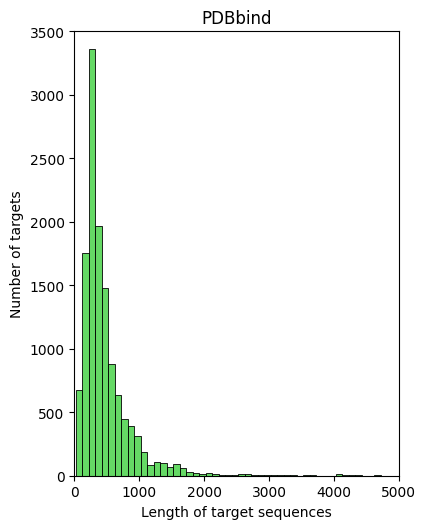

In [3]:
data_length_plot(
    length_list=str2length(pdbbind_df["Target"]), dataset="PDBbind", plot_name="PDBbindTarget", binwidth=100, 
    xlabel="Length of target sequences", ylabel="Number of targets", 
    x_start=0, x_end=5000, y_start=0, y_end=3500, color="limegreen"
    )

Min Len: 4
Max Len: 462


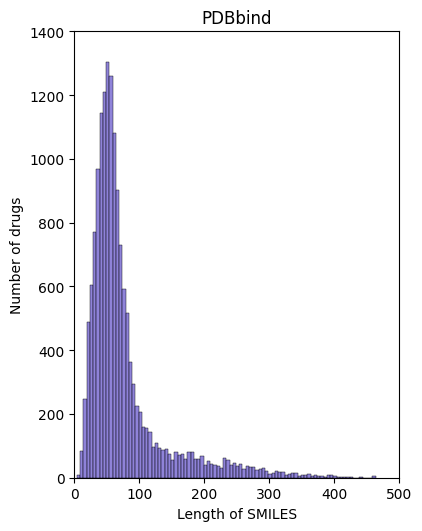

In [4]:
data_length_plot(
    length_list=str2length(pdbbind_df["Drug"]), dataset="PDBbind", plot_name="PDBbindDrug", binwidth=5, 
    xlabel="Length of SMILES", ylabel="Number of drugs", 
    x_start=0, x_end=500, y_start=0, y_end=1400, color="slateblue")

In [5]:
print(min(pdbbind_df["Y"]))
print(max(pdbbind_df["Y"]))

0.4
15.22


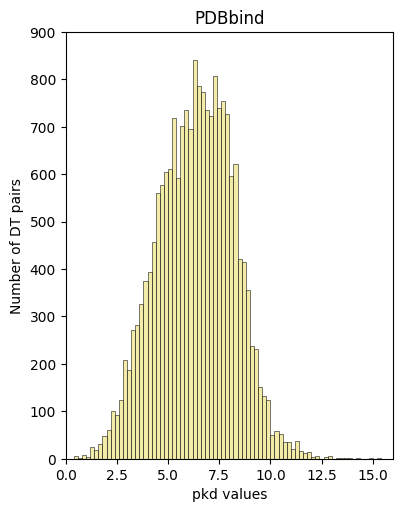

In [6]:
data_length_plot(
    length_list=pdbbind_df["Y"],  dataset="PDBbind", plot_name="PDBbindAffinity", binwidth=0.2, 
    xlabel="pkd values", ylabel="Number of DT pairs", 
    x_start=0, x_end=16, y_start=0, y_end=900, color="khaki")

## 4 dataset split

In [1]:
import pandas as pd
import numpy as np
pdbbind_df = pd.read_csv('../../../data/dta-datasets/PDBbind/pdbbind_datasets.csv')

In [2]:
pdbbind_df

,PDB_ID,Drug,Target,Y,Drug_Index,Protein_Index
0,3ZZF,CC(=O)N[C@@H](CCC(=O)O)C(=O)O,NGFSATRSTVIQLLNNISTKREVEQYLKYFTSVSQQQFAVIKVGGA...,0.40,0,0
1,3GWW,C[NH2+]CC[C@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1,REHWATRLGLILAMAGNAVGLGNFLRFPVQAAENGGGAFMIPYIIA...,0.45,1,1
2,1W8L,CC(=O)N1CCC[C@@H](C)C1,MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...,0.49,2,2
3,3FQA,Nc1cccc(C(=O)O)c1,KTIKSDEIFAAAQKLMPGGVSSPVRAFKSVGGQPIVFDRVKDAYAW...,0.49,3,3
4,1ZSB,CC(=O)Nc1nnc(S(N)(=O)=O)s1,HWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPLSV...,0.60,4,4
...,...,...,...,...,...,...
19345,7CPA,CC(C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccc...,ARSTNTFNYATYHTLDEIYDFMDLLVAQHPELVSKLQIGRSYEGRP...,13.96,19345,19399
19346,2XUF,Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cn(CCNc3c4ccc...,REDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRRFM...,14.39,19346,19400
19347,1AVD,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21,KCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKESP...,15.00,19347,19401
19348,2XUI,Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cnnn1CCNc1c3c...,EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...,15.00,19348,19402


In [3]:
# we use the time-split defined in EquiBind paper.
# https://github.com/HannesStark/EquiBind/tree/main/data
valid = np.loadtxt('../../../data/dta-datasets/PDBbind/timesplit_no_lig_overlap_val.txt', dtype=str)
valid_pdb = valid.tolist()
valid_pdb

['4lp9',
 '1me7',
 '2zv9',
 '2qo8',
 '1cw2',
 '3k5c',
 '2o65',
 '4kqq',
 '3rdv',
 '1d4w',
 '1q4l',
 '4b5w',
 '4bgg',
 '4mm5',
 '3iej',
 '3ftu',
 '830c',
 '2xye',
 '1olu',
 '2wk2',
 '4pxf',
 '5o0j',
 '1my2',
 '5czm',
 '4jit',
 '5mb1',
 '1sqp',
 '3zlw',
 '4xqu',
 '3hkq',
 '6fns',
 '5e0l',
 '2p8o',
 '4gzw',
 '3n87',
 '1lhc',
 '4itj',
 '4m7c',
 '4olh',
 '4q1e',
 '5l7e',
 '3faa',
 '5vqx',
 '3pka',
 '5x54',
 '5a9u',
 '4n9e',
 '4est',
 '1il9',
 '4igr',
 '3t2t',
 '6dar',
 '3gol',
 '3vbg',
 '2ydk',
 '4zpf',
 '5zo7',
 '4xnw',
 '1fpy',
 '2r1y',
 '6m8w',
 '2jds',
 '5icx',
 '1hwr',
 '6bj2',
 '4b4m',
 '1zsb',
 '4do3',
 '3t3i',
 '1f8a',
 '2ke1',
 '5ezx',
 '3p78',
 '4rvm',
 '3ovn',
 '5wzv',
 '4udb',
 '1okz',
 '1mpl',
 '5npc',
 '5ff6',
 '1hlf',
 '1nvq',
 '4bhf',
 '4y4g',
 '5mkz',
 '2o0u',
 '3bcs',
 '1wvc',
 '4fsl',
 '3oz1',
 '6dgt',
 '1me8',
 '2puy',
 '4odp',
 '1hpx',
 '4nrq',
 '1z2b',
 '3uik',
 '3mfv',
 '3vqh',
 '4w9g',
 '4xek',
 '4jok',
 '2wap',
 '1g50',
 '4j0p',
 '2o9a',
 '3m94',
 '4i1c',
 '5a82',
 

In [4]:
len(valid_pdb)

968

In [5]:
test = np.loadtxt('../../../data/dta-datasets/PDBbind/timesplit_test.txt', dtype=str)
test_pdb = test.tolist()
test_pdb

['6qqw',
 '6d08',
 '6jap',
 '6np2',
 '6uvp',
 '6oxq',
 '6jsn',
 '6hzb',
 '6qrc',
 '6oio',
 '6jag',
 '6moa',
 '6hld',
 '6i9a',
 '6e4c',
 '6g24',
 '6jb4',
 '6s55',
 '6seo',
 '6dyz',
 '5zk5',
 '6jid',
 '5ze6',
 '6qlu',
 '6a6k',
 '6qgf',
 '6e3z',
 '6te6',
 '6pka',
 '6g2o',
 '6jsf',
 '5zxk',
 '6qxd',
 '6n97',
 '6jt3',
 '6qtr',
 '6oy1',
 '6n96',
 '6qzh',
 '6qqz',
 '6qmt',
 '6ibx',
 '6hmt',
 '5zk7',
 '6k3l',
 '6cjs',
 '6n9l',
 '6ibz',
 '6ott',
 '6gge',
 '6hot',
 '6e3p',
 '6md6',
 '6hlb',
 '6fe5',
 '6uwp',
 '6npp',
 '6g2f',
 '6mo7',
 '6bqd',
 '6nsv',
 '6i76',
 '6n53',
 '6g2c',
 '6eeb',
 '6n0m',
 '6uvy',
 '6ovz',
 '6olx',
 '6v5l',
 '6hhg',
 '5zcu',
 '6dz2',
 '6mjq',
 '6efk',
 '6s9w',
 '6gdy',
 '6kqi',
 '6ueg',
 '6oxt',
 '6oy0',
 '6qr7',
 '6i41',
 '6cyg',
 '6qmr',
 '6g27',
 '6ggb',
 '6g3c',
 '6n4e',
 '6fcj',
 '6quv',
 '6iql',
 '6i74',
 '6qr4',
 '6rnu',
 '6jib',
 '6izq',
 '6qw8',
 '6qto',
 '6qrd',
 '6hza',
 '6e5s',
 '6dz3',
 '6e6w',
 '6cyh',
 '5zlf',
 '6om4',
 '6gga',
 '6pgp',
 '6qqv',
 '6qtq',
 

In [6]:
len(test_pdb)

363

In [7]:
pdbbind_df['PDB_ID'].isin(['3ZZF']).any()

True

In [8]:
valid_index_list = []
for pdb in valid_pdb:
    pdb_id = pdb.upper()
    if pdbbind_df['PDB_ID'].isin([pdb_id]).any():
        pdb_index = pdbbind_df[pdbbind_df['PDB_ID']==pdb_id].index.tolist()[0]
        valid_index_list.append(pdb_index)
    else:
        continue

In [9]:
valid_index_list

[8845,
 12594,
 15781,
 17009,
 8590,
 14824,
 8754,
 1939,
 4428,
 11588,
 13389,
 1084,
 15029,
 14752,
 10609,
 1467,
 18434,
 16715,
 3019,
 11261,
 802,
 4077,
 14800,
 16692,
 10562,
 10426,
 16271,
 1614,
 8324,
 5837,
 2223,
 9624,
 3314,
 4572,
 19093,
 9704,
 8536,
 16609,
 16214,
 10423,
 16121,
 9305,
 9045,
 4748,
 19011,
 15031,
 4794,
 1156,
 12664,
 294,
 10646,
 12189,
 13750,
 16113,
 11006,
 18095,
 14755,
 8000,
 3259,
 8919,
 16272,
 11752,
 16698,
 6083,
 10725,
 4,
 2343,
 4061,
 4656,
 5691,
 12114,
 11736,
 18068,
 365,
 10715,
 18296,
 16527,
 1718,
 2148,
 4805,
 6742,
 16455,
 1234,
 135,
 3859,
 6333,
 5377,
 3139,
 14578,
 17532,
 13340,
 12595,
 3294,
 4068,
 19248,
 1237,
 9561,
 4610,
 353,
 7766,
 5585,
 6842,
 2283,
 10549,
 9069,
 12989,
 1793,
 4966,
 15971,
 6667,
 12534,
 10306,
 16887,
 12216,
 1375,
 6566,
 11182,
 6520,
 8843,
 2761,
 2987,
 17014,
 8075,
 7447,
 17263,
 1758,
 7838,
 323,
 12367,
 2546,
 12736,
 2763,
 129,
 6496,
 15210,
 190

In [10]:
len(valid_index_list) # 6 lose

962

In [11]:
file = open('../../../data/dta-datasets/PDBbind/valid_index.txt', 'w')
file.writelines(str(valid_index_list))
file.close()

In [12]:
test_index_list = []
for pdb in test_pdb:
    pdb_id = pdb.upper()
    if pdbbind_df['PDB_ID'].isin([pdb_id]).any():
        pdb_index = pdbbind_df[pdbbind_df['PDB_ID']==pdb_id].index.tolist()[0]
        test_index_list.append(pdb_index)
    else:
        print(pdb_id)

In [13]:
test_index_list

[3942,
 5669,
 4152,
 11210,
 2164,
 19268,
 16950,
 17973,
 4412,
 10189,
 3256,
 12179,
 18357,
 18984,
 18917,
 495,
 7973,
 8813,
 4006,
 18347,
 16780,
 4989,
 1109,
 3675,
 13693,
 8115,
 14794,
 10305,
 7817,
 11109,
 17044,
 6323,
 8160,
 5246,
 16660,
 3677,
 19054,
 6148,
 17229,
 11028,
 11666,
 17607,
 12040,
 10876,
 12772,
 18811,
 10856,
 14415,
 6149,
 7288,
 3009,
 17603,
 5075,
 19061,
 18477,
 14035,
 8269,
 5292,
 4834,
 9537,
 14973,
 4955,
 15181,
 3729,
 5748,
 7472,
 8116,
 1861,
 5987,
 1523,
 14796,
 6877,
 17833,
 15187,
 11204,
 12795,
 6248,
 15856,
 3906,
 18923,
 18484,
 12484,
 2580,
 2495,
 15398,
 842,
 6019,
 11582,
 15694,
 12478,
 720,
 18529,
 6280,
 8947,
 2163,
 7379,
 6382,
 9652,
 3676,
 11948,
 18480,
 9796,
 17887,
 18929,
 864,
 1268,
 6216,
 4320,
 11946,
 4494,
 1671,
 3875,
 5927,
 13478,
 4597,
 15533,
 7465,
 18992,
 15078,
 2509,
 12854,
 4410,
 18579,
 11111,
 11029,
 16727,
 4004,
 18711,
 16983,
 8946,
 6020,
 6927,
 18688,
 19219,


In [14]:
len(test_index_list)  # 0 loss

363

In [15]:
file = open('../../../data/dta-datasets/PDBbind/test_index.txt', 'w')
file.writelines(str(test_index_list))
file.close()

In [16]:
test_index_list.extend(valid_index_list)

In [17]:
len(test_index_list)

1325

In [18]:
test_index_list

[3942,
 5669,
 4152,
 11210,
 2164,
 19268,
 16950,
 17973,
 4412,
 10189,
 3256,
 12179,
 18357,
 18984,
 18917,
 495,
 7973,
 8813,
 4006,
 18347,
 16780,
 4989,
 1109,
 3675,
 13693,
 8115,
 14794,
 10305,
 7817,
 11109,
 17044,
 6323,
 8160,
 5246,
 16660,
 3677,
 19054,
 6148,
 17229,
 11028,
 11666,
 17607,
 12040,
 10876,
 12772,
 18811,
 10856,
 14415,
 6149,
 7288,
 3009,
 17603,
 5075,
 19061,
 18477,
 14035,
 8269,
 5292,
 4834,
 9537,
 14973,
 4955,
 15181,
 3729,
 5748,
 7472,
 8116,
 1861,
 5987,
 1523,
 14796,
 6877,
 17833,
 15187,
 11204,
 12795,
 6248,
 15856,
 3906,
 18923,
 18484,
 12484,
 2580,
 2495,
 15398,
 842,
 6019,
 11582,
 15694,
 12478,
 720,
 18529,
 6280,
 8947,
 2163,
 7379,
 6382,
 9652,
 3676,
 11948,
 18480,
 9796,
 17887,
 18929,
 864,
 1268,
 6216,
 4320,
 11946,
 4494,
 1671,
 3875,
 5927,
 13478,
 4597,
 15533,
 7465,
 18992,
 15078,
 2509,
 12854,
 4410,
 18579,
 11111,
 11029,
 16727,
 4004,
 18711,
 16983,
 8946,
 6020,
 6927,
 18688,
 19219,


In [19]:
train_index_list = []
for index in range(pdbbind_df.shape[0]):
    if index not in test_index_list:
        train_index_list.append(index)

In [20]:
train_index_list

[0,
 1,
 2,
 3,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 130,
 131,
 132,
 133,
 134,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 172,
 173,
 174,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 192,
 193,
 194,
 195,


In [21]:
len(train_index_list)

18025

In [22]:
file = open('../../../data/dta-datasets/PDBbind/train_index.txt', 'w')
file.writelines(str(train_index_list))
file.close()

### PDBbind pocket in Molecule format pkl file

In [1]:
import warnings
import torch
import pickle
import pandas as pd

from torchdrug import data
from rdkit import Chem
from tqdm import tqdm
from torchdrug import utils

warnings.filterwarnings("ignore")

In [2]:
pre = "../../../data/dta-datasets/PDBbind"
affinity_csv = '../../../data/dta-datasets/PDBbind/pdbbind_datasets.csv'

In [3]:
pdbbind_df= pd.read_csv(affinity_csv)
pdbbind_df

,PDB_ID,Drug,Target,Y,Drug_Index,Protein_Index
0,3ZZF,CC(=O)N[C@@H](CCC(=O)O)C(=O)O,NGFSATRSTVIQLLNNISTKREVEQYLKYFTSVSQQQFAVIKVGGA...,0.40,0,0
1,3GWW,C[NH2+]CC[C@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1,REHWATRLGLILAMAGNAVGLGNFLRFPVQAAENGGGAFMIPYIIA...,0.45,1,1
2,1W8L,CC(=O)N1CCC[C@@H](C)C1,MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...,0.49,2,2
3,3FQA,Nc1cccc(C(=O)O)c1,KTIKSDEIFAAAQKLMPGGVSSPVRAFKSVGGQPIVFDRVKDAYAW...,0.49,3,3
4,1ZSB,CC(=O)Nc1nnc(S(N)(=O)=O)s1,HWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPLSV...,0.60,4,4
...,...,...,...,...,...,...
19345,7CPA,CC(C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccc...,ARSTNTFNYATYHTLDEIYDFMDLLVAQHPELVSKLQIGRSYEGRP...,13.96,19345,19399
19346,2XUF,Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cn(CCNc3c4ccc...,REDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRRFM...,14.39,19346,19400
19347,1AVD,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21,KCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKESP...,15.00,19347,19401
19348,2XUI,Nc1ccc2c(c1)C(c1ccccc1)N(CCCCCCc1cnnn1CCNc1c3c...,EGREDPQLLVRVRGGQLRGIRLKAPGGPVSAFLGIPFAEPPVGSRR...,15.00,19348,19402


In [4]:
pdbbind_df.PDB_ID

0        3ZZF
1        3GWW
2        1W8L
3        3FQA
4        1ZSB
         ... 
19345    7CPA
19346    2XUF
19347    1AVD
19348    2XUI
19349    2AVI
Name: PDB_ID, Length: 19350, dtype: object

In [5]:
protein_list = []

for pdb in tqdm(pdbbind_df.PDB_ID):
    pdbname = pdb.lower()
    pdb_file = f"{pre}/PDBbind_file/{pdbname}/{pdbname}_pocket.pdb"
    mol = Chem.MolFromPDBFile(pdb_file, sanitize=False)
    protein = data.Molecule.from_molecule(mol, atom_feature='default', bond_feature='default', mol_feature=None) 
    with protein.atom():
        protein.atom_source = torch.ones([protein.num_atom.item()])
    protein_list.append(protein)

100%|██████████| 19350/19350 [11:43<00:00, 27.51it/s]


In [6]:
protein_list

[Molecule(num_atom=436, num_bond=840),
 Molecule(num_atom=514, num_bond=1008),
 Molecule(num_atom=310, num_bond=584),
 Molecule(num_atom=398, num_bond=758),
 Molecule(num_atom=492, num_bond=984),
 Molecule(num_atom=235, num_bond=440),
 Molecule(num_atom=373, num_bond=744),
 Molecule(num_atom=431, num_bond=832),
 Molecule(num_atom=342, num_bond=644),
 Molecule(num_atom=370, num_bond=642),
 Molecule(num_atom=318, num_bond=582),
 Molecule(num_atom=436, num_bond=862),
 Molecule(num_atom=428, num_bond=786),
 Molecule(num_atom=447, num_bond=812),
 Molecule(num_atom=382, num_bond=744),
 Molecule(num_atom=449, num_bond=890),
 Molecule(num_atom=529, num_bond=1052),
 Molecule(num_atom=197, num_bond=386),
 Molecule(num_atom=407, num_bond=732),
 Molecule(num_atom=388, num_bond=698),
 Molecule(num_atom=407, num_bond=772),
 Molecule(num_atom=391, num_bond=738),
 Molecule(num_atom=180, num_bond=350),
 Molecule(num_atom=315, num_bond=588),
 Molecule(num_atom=648, num_bond=1250),
 Molecule(num_atom=368

In [10]:
len(protein_list)

19350

In [7]:
protein_list[0].node_position

tensor([[ 5.4330, 36.8520, 15.7800],
        [ 5.2100, 37.8600, 15.9070],
        [ 5.8470, 36.3800, 14.4620],
        ...,
        [ 6.3490, 35.7120,  0.9570],
        [ 6.0640, 40.1660,  3.8630],
        [13.4970, 38.8680,  9.2670]])

In [8]:
protein_list[0].atom_source

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [9]:
protein_list[0].edge_feature.shape

torch.Size([840, 18])

In [11]:
protein_pkl = '../../../data/dta-datasets/PDBbind/pocket_Protein.pkl'
with utils.smart_open(protein_pkl, "wb") as fout:
    pickle.dump(protein_list, fout)

直接添加属性

In [5]:
import pickle
import torch
from tqdm import tqdm
from torchdrug import utils, data

In [2]:
drug_pkl = '../../../data/dta-datasets/PDBbind/PDBbind_pocket/3dRandom_Molecule.pkl'
with utils.smart_open(drug_pkl, "rb") as fin:
    drug_list = pickle.load(fin)

In [3]:
drug_list[0].node_position

tensor([[-0.3470, -0.3580, -0.1551],
        [-0.5255, -1.8103, -0.1912],
        [-1.5105, -2.3423,  0.3484],
        [ 0.3904, -2.6162, -0.8234],
        [ 0.9278,  0.0848,  0.4479],
        [ 2.1449, -0.3810, -0.2683],
        [ 3.3742,  0.1583,  0.4330],
        [ 3.4754,  0.0141,  1.6549],
        [ 4.3375,  0.7951, -0.3193],
        [-2.4412,  0.9599, -0.1910],
        [-3.6268,  1.5664,  0.4768],
        [-2.2429,  1.0920, -1.4372],
        [-1.5007,  0.2166,  0.5563]])

In [6]:
for molecule in drug_list:
    with molecule.atom():
        molecule.atom_source = torch.zeros([molecule.num_atom.item()])

In [7]:
drug_list[0].node_position

tensor([[-0.3470, -0.3580, -0.1551],
        [-0.5255, -1.8103, -0.1912],
        [-1.5105, -2.3423,  0.3484],
        [ 0.3904, -2.6162, -0.8234],
        [ 0.9278,  0.0848,  0.4479],
        [ 2.1449, -0.3810, -0.2683],
        [ 3.3742,  0.1583,  0.4330],
        [ 3.4754,  0.0141,  1.6549],
        [ 4.3375,  0.7951, -0.3193],
        [-2.4412,  0.9599, -0.1910],
        [-3.6268,  1.5664,  0.4768],
        [-2.2429,  1.0920, -1.4372],
        [-1.5007,  0.2166,  0.5563]])

In [8]:
drug_list[0].atom_source

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [10]:
drug_list[0].edge_feature.shape

torch.Size([24, 19])

In [11]:
drug_pkl = '../../../data/dta-datasets/PDBbind/PDBbind_pocket/DrugInMolecule_Molecule.pkl'
with utils.smart_open(drug_pkl, "wb") as fout:
    pickle.dump(drug_list, fout)

***

## Demo test

In [1]:
from torchdrug import datasets

In [2]:
dataset = datasets.PDBBind("../../../data/dta-datasets/PDBbind/PDBbind_pocket/", protein_method='gearnet', drug_method='3d')

==================== Using 3d drug method and gearnet protein method! ====================


Constructing Dataset from pkl file: 100%|██████████| 19354/19354 [00:00<00:00, 42743.85it/s]


In [3]:
dataset

PDBBind(
  #sample: 19354
  #task: 1
)

In [4]:
dataset.data

[[PackedProtein(batch_size=1, num_atoms=[1161], num_bonds=[23749], num_residues=[1161]),
  Molecule(num_atom=13, num_bond=24)],
 [PackedProtein(batch_size=1, num_atoms=[501], num_bonds=[9852], num_residues=[501]),
  Molecule(num_atom=22, num_bond=46)],
 [PackedProtein(batch_size=1, num_atoms=[165], num_bonds=[3709], num_residues=[165]),
  Molecule(num_atom=10, num_bond=20)],
 [PackedProtein(batch_size=1, num_atoms=[852], num_bonds=[19860], num_residues=[852]),
  Molecule(num_atom=10, num_bond=20)],
 [PackedProtein(batch_size=1, num_atoms=[257], num_bonds=[5615], num_residues=[257]),
  Molecule(num_atom=13, num_bond=26)],
 [PackedProtein(batch_size=1, num_atoms=[611], num_bonds=[14390], num_residues=[611]),
  Molecule(num_atom=12, num_bond=24)],
 [PackedProtein(batch_size=1, num_atoms=[939], num_bonds=[20431], num_residues=[939]),
  Molecule(num_atom=17, num_bond=36)],
 [PackedProtein(batch_size=1, num_atoms=[295], num_bonds=[6629], num_residues=[295]),
  Molecule(num_atom=9, num_bond=1

In [5]:
dataset.data[0][0].residue_feature.shape

torch.Size([1161, 21])

In [6]:
dataset.data[0][1].node_feature.shape

torch.Size([13, 67])

In [7]:
dataset.data[0][0].num_relation

tensor(7)

In [8]:
dataset.data[0][0].edge_list.tolist()

[[166, 0, 0],
 [167, 0, 0],
 [165, 0, 0],
 [67, 0, 0],
 [66, 0, 0],
 [65, 0, 0],
 [64, 0, 0],
 [63, 0, 0],
 [62, 0, 0],
 [164, 0, 0],
 [34, 0, 0],
 [167, 1, 0],
 [165, 1, 0],
 [67, 1, 0],
 [66, 1, 0],
 [65, 1, 0],
 [64, 1, 0],
 [63, 1, 0],
 [62, 1, 0],
 [875, 1, 0],
 [876, 1, 0],
 [64, 2, 0],
 [63, 2, 0],
 [61, 2, 0],
 [62, 2, 0],
 [29, 2, 0],
 [66, 2, 0],
 [65, 2, 0],
 [877, 2, 0],
 [874, 2, 0],
 [875, 2, 0],
 [876, 2, 0],
 [879, 2, 0],
 [873, 2, 0],
 [64, 3, 0],
 [8, 3, 0],
 [63, 3, 0],
 [60, 3, 0],
 [62, 3, 0],
 [65, 3, 0],
 [9, 3, 0],
 [873, 3, 0],
 [874, 3, 0],
 [875, 3, 0],
 [876, 3, 0],
 [878, 3, 0],
 [879, 3, 0],
 [872, 3, 0],
 [64, 4, 0],
 [12, 4, 0],
 [63, 4, 0],
 [60, 4, 0],
 [61, 4, 0],
 [62, 4, 0],
 [65, 4, 0],
 [11, 4, 0],
 [10, 4, 0],
 [9, 4, 0],
 [874, 4, 0],
 [875, 4, 0],
 [876, 4, 0],
 [878, 4, 0],
 [879, 4, 0],
 [873, 4, 0],
 [872, 4, 0],
 [64, 5, 0],
 [63, 5, 0],
 [60, 5, 0],
 [125, 5, 0],
 [11, 5, 0],
 [10, 5, 0],
 [874, 5, 0],
 [875, 5, 0],
 [873, 5, 0],
 [871, 5,

In [9]:
dataset.smiles

['CC(=O)N[C@@H](CCC(=O)O)C(=O)O',
 'C[NH2+]CC[C@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1',
 'CC(=O)N1CCC[C@@H](C)C1',
 'Nc1cccc(C(=O)O)c1',
 'CC(=O)Nc1nnc(S(N)(=O)=O)s1',
 'CO[C@@H]1O[C@@H](C)[C@@H](O)[C@@H](O)[C@@H]1O',
 '[NH3+][C@](CF)(Cc1c[nH]c2ccccc12)C(=O)[O-]',
 'CSCC[C@H]([NH3+])C(=O)O',
 'O=P(O)(O)OC[C@H]1O[C@@H](O)[C@@H](O)[C@@H](O)[C@@H]1O',
 'O=C(O)CC(O)(CC(=O)O)C(=O)O',
 'OCC(O)CO',
 'C[NH2+]CCCC[C@H]([NH3+])C(=O)O',
 'OC[C@H]1O[C@@H](O[C@H]2[C@H](O)[C@@H](O)[C@@H](O)O[C@@H]2CO)[C@H](O)[C@@H](O)[C@@H]1O',
 'OC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O)[C@@H](O)O[C@@H]2CO)[C@H](O)[C@@H](O)[C@@H]1O',
 'O=C(O)COP(=O)(O)O',
 'Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@](=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O',
 'COc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC',
 '[NH3+][C@@H](Cc1c[nH]c2ccccc12)C(=O)[O-]',
 'O=C(O)CCC(=O)O',
 'O=C(O)CC(O)(CC(=O)O)C(=O)O',
 '[H]/N=C(\\N)NC[C@H]([NH3+])C(=O)O',
 '[H]/N=C(\\N)NC[C@H]([NH3+])C(=O)O',
 'Nc1ncnc2c1ncn2[C@@H]1O[C@@H]2CO[P@@](=O)(O)O[C@H]2[C@H]1O',
 'O=C1O[C@H]([C@H](O)

In [10]:
dataset.targets

{'affinity': [0.4,
  0.45,
  0.49,
  0.49,
  0.6,
  0.66,
  0.75,
  0.82,
  0.82,
  0.82,
  0.96,
  1.0,
  1.0,
  1.0,
  1.05,
  1.1,
  1.11,
  1.11,
  1.24,
  1.24,
  1.26,
  1.26,
  1.27,
  1.28,
  1.3,
  1.3,
  1.3,
  1.3,
  1.31,
  1.31,
  1.31,
  1.31,
  1.35,
  1.35,
  1.36,
  1.36,
  1.4,
  1.4,
  1.4,
  1.4,
  1.4,
  1.4,
  1.43,
  1.44,
  1.44,
  1.45,
  1.49,
  1.49,
  1.49,
  1.52,
  1.52,
  1.52,
  1.54,
  1.55,
  1.57,
  1.57,
  1.58,
  1.58,
  1.59,
  1.6,
  1.6,
  1.62,
  1.62,
  1.64,
  1.64,
  1.66,
  1.68,
  1.68,
  1.7,
  1.7,
  1.7,
  1.7,
  1.7,
  1.7,
  1.71,
  1.72,
  1.72,
  1.72,
  1.72,
  1.72,
  1.74,
  1.74,
  1.74,
  1.75,
  1.75,
  1.77,
  1.78,
  1.78,
  1.79,
  1.8,
  1.8,
  1.82,
  1.82,
  1.82,
  1.82,
  1.82,
  1.82,
  1.85,
  1.85,
  1.88,
  1.88,
  1.88,
  1.89,
  1.9,
  1.9,
  1.91,
  1.92,
  1.92,
  1.92,
  1.94,
  1.94,
  1.95,
  1.95,
  1.96,
  1.96,
  1.96,
  1.98,
  1.98,
  1.98,
  1.99,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,


In [11]:
len(dataset.targets['affinity'])

19354

In [12]:
train_set, valid_set, test_set = dataset.deepdta_split()

In [13]:
train_set

In [14]:
train_set.indices

[0,
 1,
 2,
 3,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 130,
 131,
 132,
 133,
 134,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 172,
 173,
 174,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 192,
 193,
 194,
 195,
